In [1]:
# setup
from mlwpy import *

digits = datasets.load_digits()
digits_ftrs, digits_tgt = digits.data, digits.target

diabetes = datasets.load_diabetes()
diabetes_ftrs, diabetes_tgt = diabetes.data, diabetes.target

iris = datasets.load_iris()
tts = skms.train_test_split(iris.data, iris.target, 
                            test_size=.75, stratify=iris.target)
(iris_train_ftrs, iris_test_ftrs, 
 iris_train_tgt,  iris_test_tgt) = tts

In [2]:
base_estimators = [linear_model.LogisticRegression(),
                   tree.DecisionTreeClassifier(max_depth=3),
                   naive_bayes.GaussianNB()]
base_estimators = [(get_model_name(m), m) for m in base_estimators]

ensemble_model = ensemble.VotingClassifier(estimators=base_estimators)
skms.cross_val_score(ensemble_model, digits_ftrs, digits_tgt)

array([0.8571, 0.8397, 0.8742])

In [3]:
dataset = np.array([1,5,10,10,17,20,35])
def compute_mean(data):
    return np.sum(data) / data.size
compute_mean(dataset)

14.0

In [4]:
def bootstrap_sample(data):
    N   = len(data)
    idx = np.arange(N)
    bs_idx = np.random.choice(idx, N, 
                              replace=True) # default added for clarity
    return data[bs_idx]

In [5]:
bsms = []
for i in range(5):
    bs_sample = bootstrap_sample(dataset)
    bs_mean = compute_mean(bs_sample)
    bsms.append(bs_mean)
    
    print(bs_sample, "{:5.2f}".format(bs_mean))

[35 10  1  1 10 10 10] 11.00
[20 35 20 20 20 20 20] 22.14
[17 10 20 10 10  5 17] 12.71
[20  1 10 35  1 17 10] 13.43
[17 10 10 10  1  1 10]  8.43


In [6]:
print("{:5.2f}".format(sum(bsms) / len(bsms)))

13.54


In [7]:
def compute_bootstrap_statistic(data, num_boots, statistic):
    ' repeatedly calculate statistic on num_boots bootstrap samples'
    # no comments from the peanut gallery
    bs_stats = [statistic(bootstrap_sample(data)) for i in range(num_boots)]
    # return the average of the calculated statistics
    return np.sum(bs_stats) / num_boots

bs_mean = compute_bootstrap_statistic(dataset, 100, compute_mean)
print("{:5.2f}".format(bs_mean))

13.86


In [8]:
def make_knn_statistic(new_example):
    def knn_statistic(dataset):
        ftrs, tgt = dataset[:,:-1], dataset[:,-1]
        knn = neighbors.KNeighborsRegressor(n_neighbors=3).fit(ftrs, tgt)
        return knn.predict(new_example)
    return knn_statistic

In [9]:
# have to slightly massage data for this scenario
# we use last example as our fixed test example
diabetes_dataset = np.c_[diabetes_ftrs, diabetes_tgt]
ks = make_knn_statistic(diabetes_ftrs[-1].reshape(1,-1))
compute_bootstrap_statistic(diabetes_dataset, 100, ks)

74.00666666666667

In [10]:
def bagged_learner(dataset, base_model, num_models=10):
    # pseudo-code:  needs tweaks to run
    models = []
    for n in num_models:
        bs_sample = np.random.choice(dataset, N, replace=True)
        models.append(base_model().fit(*bs_sample))
    return models

def bagged_predict_class(models, example):
    # take the most frequent (mode) predicted class as result
    preds = [m.predict(example) for m in models]
    return pd.Series(preds).mode() 

In [11]:
def my_boosted_classifier(base_classifier, bc_args, 
                          examples, targets, M):
    N = len(examples)
    data_weights = np.full(N, 1/N)
    models, model_weights = [], []

    for i in range(M):
        weighted_dataset = reweight((examples,targets), 
                                    data_weights)
        this_model = base_classifier(*bc_args).fit(*weighted_dataset)

        errors = this_model.predict(examples) != targets
        weighted_error = np.dot(weights, errors)
        
        # magic reweighting steps
        this_model_wgt = np.log(1-weighted_error)/weighted_error
        data_weights   *= np.exp(this_model_wgt * errors)
        data_weights   /= data_weights.sum() # normalize to 1.0
        
        models.append(this_model)
        model_weights.append(this_model_wgt)
        
    return ensemble.VotingClassifier(models, 
                                     voting='soft', 
                                     weights=model_weights)

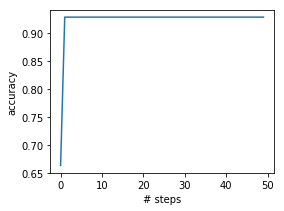

In [12]:
model = ensemble.AdaBoostClassifier()
stage_preds = (model.fit(iris_train_ftrs, iris_train_tgt)
                    .staged_predict(iris_test_ftrs))
stage_scores = [metrics.accuracy_score(iris_test_tgt,
                                       pred) for pred in stage_preds]
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(stage_scores)
ax.set_xlabel('# steps')
ax.set_ylabel('accuracy');

In [13]:
def fit_predict_score(model, ds):
    return skms.cross_val_score(model, *ds, cv=10).mean()

stump  = tree.DecisionTreeClassifier(max_depth=1)
dtree  = tree.DecisionTreeClassifier(max_depth=3)
forest = ensemble.RandomForestClassifier(max_features=1, max_depth=1)

tree_classifiers = {'stump' : stump, 'dtree' : dtree, 'forest': forest}

max_est = 100
data = (digits_ftrs, digits_tgt)
stump_score   = fit_predict_score(stump, data)
tree_score    = fit_predict_score(dtree, data)
forest_scores = [fit_predict_score(forest.set_params(n_estimators=n),
                                   data) 
                 for n in range(1,max_est+1)]

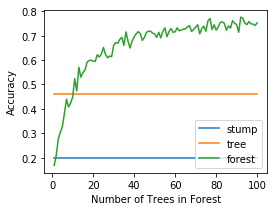

In [14]:
fig, ax = plt.subplots(figsize=(4,3))

xs = list(range(1,max_est+1))
ax.plot(xs, np.repeat(stump_score, max_est), label='stump')
ax.plot(xs, np.repeat(tree_score, max_est),  label='tree')
ax.plot(xs, forest_scores, label='forest')

ax.set_xlabel('Number of Trees in Forest')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right');

In [15]:
def my_manual_cv(dataset, k=10):
    ' manually generate cv-folds from dataset '
    # expect ftrs, tgt tuple
    ds_ftrs, ds_tgt = dataset
    manual_cv = skms.StratifiedKFold(k).split(ds_ftrs, 
                                              ds_tgt)
    for (train_idx, test_idx) in manual_cv:
        train_ftrs = ds_ftrs[train_idx]
        test_ftrs  = ds_ftrs[test_idx]
        train_tgt = ds_tgt[train_idx]
        test_tgt  = ds_tgt[test_idx]
        
        yield (train_ftrs, test_ftrs,
               train_tgt, test_tgt)

In [16]:
AdaBC  = ensemble.AdaBoostClassifier
GradBC = ensemble.GradientBoostingClassifier
boosted_classifiers = {'boost(Ada)' : AdaBC(learning_rate=2.0),
                       'boost(Grad)' : GradBC(loss="deviance")}
mean_accs = {}
for name, model in boosted_classifiers.items():
    model.set_params(n_estimators=max_est)
    accs = []
    for tts in my_manual_cv((digits_ftrs, digits_tgt)):
        train_f, test_f, train_t, test_t = tts
        s_preds = (model.fit(train_f, train_t)
                        .staged_predict(test_f))
        s_scores = [metrics.accuracy_score(test_t, p) for p in s_preds]
        accs.append(s_scores)
    mean_accs[name] = np.array(accs).mean(axis=0)
mean_acc_df = pd.DataFrame.from_dict(mean_accs,orient='columns')

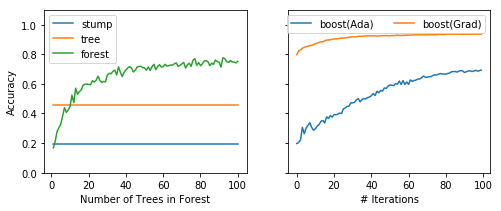

In [17]:
xs = list(range(1,max_est+1))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3),sharey=True)
ax1.plot(xs, np.repeat(stump_score, max_est), label='stump')
ax1.plot(xs, np.repeat(tree_score, max_est),  label='tree')
ax1.plot(xs, forest_scores, label='forest')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Trees in Forest')
ax1.legend()

mean_acc_df.plot(ax=ax2)
ax2.set_ylim(0.0, 1.1)
ax2.set_xlabel('# Iterations')
ax2.legend(ncol=2);

In [18]:
# conda install py-xgboost
import xgboost
# gives us xgboost.XGBRegressor, xgboost.XGBClassifier
# which interface nicely with sklearn
# see docs at
# http://xgboost.readthedocs.io/en/latest/parameter.html
xgbooster = xgboost.XGBClassifier(objective="multi:softmax")
scores = skms.cross_val_score(xgbooster, iris.data, iris.target, cv=10)
print(scores)

[1.     0.9333 1.     0.9333 0.9333 0.9333 0.9333 0.9333 1.     1.    ]
